# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


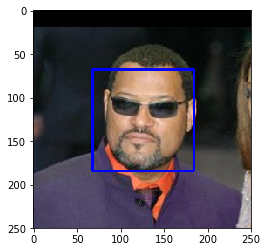

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def test_face_detector_performance():    
    detected_human_faces = 0
    for path in human_files_short:
        if face_detector(path):
            detected_human_faces += 1
    print("Detected human faces: ",detected_human_faces,"/ 100")

    detected_human_faces = 0
    for path in dog_files_short:
        if face_detector(path):
            detected_human_faces += 1
    print("Detected human faces out of dog faces: ",detected_human_faces, "/ 0")
    
test_face_detector_performance()

Detected human faces:  99 / 100
Detected human faces out of dog faces:  12 / 0


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
# copied these functions from Step 2 here because I need them for the optional assignment

from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True   

dog_files = np.array(glob("dogImages/*/*/*"))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.concatenate([paths_to_tensor(human_files).astype('float32')/255, paths_to_tensor(dog_files).astype('float32')/255]),
                                                    np_utils.to_categorical(np.concatenate([np.zeros(len(human_files)), np.ones(len(dog_files))]),2), test_size=0.2, random_state=42, shuffle=True)

100%|██████████████████████████████████████████████████████████████████████████████| 8351/8351 [02:25<00:00, 57.45it/s]


In [8]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=8, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
__________

In [9]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.dog_vs_human.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=500, callbacks=[checkpointer], verbose=2)

Train on 13813 samples, validate on 3454 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.52029, saving model to saved_models/weights.best.dog_vs_human.hdf5
65s - loss: 0.6945 - acc: 0.6191 - val_loss: 0.5203 - val_acc: 0.6740
Epoch 2/20
Epoch 00001: val_loss improved from 0.52029 to 0.15092, saving model to saved_models/weights.best.dog_vs_human.hdf5
19s - loss: 0.5063 - acc: 0.8105 - val_loss: 0.1509 - val_acc: 0.9473
Epoch 3/20
Epoch 00002: val_loss improved from 0.15092 to 0.08657, saving model to saved_models/weights.best.dog_vs_human.hdf5
19s - loss: 0.2010 - acc: 0.9188 - val_loss: 0.0866 - val_acc: 0.9696
Epoch 4/20
Epoch 00003: val_loss did not improve
19s - loss: 0.1427 - acc: 0.9495 - val_loss: 0.1576 - val_acc: 0.9461
Epoch 5/20
Epoch 00004: val_loss improved from 0.08657 to 0.06396, saving model to saved_models/weights.best.dog_vs_human.hdf5
19s - loss: 0.1056 - acc: 0.9658 - val_loss: 0.0640 - val_acc: 0.9820
Epoch 6/20
Epoch 00005: val_loss improved from 0

In [10]:
model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in X_test]

test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(y_test, axis=1))/len(model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 99.6062%


In [11]:
import os

def dog_vs_human_cnn_detector(img_path): 
    if np.argmax(model.predict(path_to_tensor(img_path))) == 0:
        return "human"
    else:
        return "dog"     
   
for file in np.random.choice(np.concatenate([dog_files, human_files]), 10):
    print(dog_vs_human_cnn_detector(file) + " detected for file: " + os.path.basename(file))

human detected for file: Richard_Gephardt_0001.jpg
dog detected for file: French_bulldog_04824.jpg
dog detected for file: Komondor_06380.jpg
human detected for file: Julie_Gerberding_0011.jpg
dog detected for file: Kerry_blue_terrier_06285.jpg
dog detected for file: Elvis_Costello_0001.jpg
dog detected for file: Norfolk_terrier_07050.jpg
dog detected for file: Boykin_spaniel_02468.jpg
human detected for file: Nick_Nolte_0004.jpg
human detected for file: Fernando_Henrique_Cardoso_0008.jpg


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [12]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [13]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [14]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [16]:
detected_human_faces = 0
for path in human_files_short:
    if dog_detector(path):
        detected_human_faces += 1
print("Detected dogs out of human faces: ",detected_human_faces,"/ 100")

detected_human_faces = 0
for path in dog_files_short:
    if dog_detector(path):
        detected_human_faces += 1
print("Detected dog faces out of dog faces: ",detected_human_faces, "/ 0")

Detected dogs out of human faces:  1 / 100
Detected dog faces out of dog faces:  100 / 0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [17]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:15<00:00, 55.10it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [18]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


model = Sequential()
model.add(Conv2D(filters=8, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))



model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
__________

### Compile the Model

In [19]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [20]:
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 300
batch_size = 133

datagen_train = ImageDataGenerator(
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    horizontal_flip=True) 

datagen_train.fit(train_tensors)

history = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(valid_tensors, valid_targets),
                    validation_steps=valid_tensors.shape[0] // batch_size, workers=8)

Epoch 1/300
Epoch 00000: val_loss improved from inf to 4.87746, saving model to saved_models/weights.best.from_scratch.hdf5
15s - loss: 4.8889 - acc: 0.0083 - val_loss: 4.8775 - val_acc: 0.0108
Epoch 2/300
Epoch 00001: val_loss improved from 4.87746 to 4.83848, saving model to saved_models/weights.best.from_scratch.hdf5
11s - loss: 4.8669 - acc: 0.0121 - val_loss: 4.8385 - val_acc: 0.0168
Epoch 3/300
Epoch 00002: val_loss improved from 4.83848 to 4.70525, saving model to saved_models/weights.best.from_scratch.hdf5
11s - loss: 4.8015 - acc: 0.0146 - val_loss: 4.7053 - val_acc: 0.0263
Epoch 4/300
Epoch 00003: val_loss improved from 4.70525 to 4.59775, saving model to saved_models/weights.best.from_scratch.hdf5
13s - loss: 4.7093 - acc: 0.0206 - val_loss: 4.5977 - val_acc: 0.0287
Epoch 5/300
Epoch 00004: val_loss improved from 4.59775 to 4.59175, saving model to saved_models/weights.best.from_scratch.hdf5
11s - loss: 4.6313 - acc: 0.0301 - val_loss: 4.5917 - val_acc: 0.0347
Epoch 6/300
Ep

Epoch 49/300
Epoch 00048: val_loss improved from 3.15641 to 3.13637, saving model to saved_models/weights.best.from_scratch.hdf5
11s - loss: 2.8948 - acc: 0.2579 - val_loss: 3.1364 - val_acc: 0.1988
Epoch 50/300
Epoch 00049: val_loss improved from 3.13637 to 3.11002, saving model to saved_models/weights.best.from_scratch.hdf5
11s - loss: 2.8594 - acc: 0.2567 - val_loss: 3.1100 - val_acc: 0.2204
Epoch 51/300
Epoch 00050: val_loss improved from 3.11002 to 3.07705, saving model to saved_models/weights.best.from_scratch.hdf5
11s - loss: 2.8590 - acc: 0.2555 - val_loss: 3.0771 - val_acc: 0.2204
Epoch 52/300
Epoch 00051: val_loss did not improve
11s - loss: 2.8069 - acc: 0.2797 - val_loss: 3.1971 - val_acc: 0.2323
Epoch 53/300
Epoch 00052: val_loss did not improve
12s - loss: 2.7812 - acc: 0.2730 - val_loss: 3.1511 - val_acc: 0.2299
Epoch 54/300
Epoch 00053: val_loss did not improve
11s - loss: 2.7442 - acc: 0.2848 - val_loss: 3.1505 - val_acc: 0.2144
Epoch 55/300
Epoch 00054: val_loss did n

Epoch 110/300
Epoch 00109: val_loss did not improve
11s - loss: 1.8559 - acc: 0.4868 - val_loss: 2.9547 - val_acc: 0.3066
Epoch 111/300
Epoch 00110: val_loss did not improve
12s - loss: 1.8614 - acc: 0.4727 - val_loss: 2.8264 - val_acc: 0.3090
Epoch 112/300
Epoch 00111: val_loss did not improve
11s - loss: 1.8410 - acc: 0.4828 - val_loss: 2.9354 - val_acc: 0.3018
Epoch 113/300
Epoch 00112: val_loss did not improve
11s - loss: 1.8344 - acc: 0.4856 - val_loss: 2.9519 - val_acc: 0.3030
Epoch 114/300
Epoch 00113: val_loss did not improve
11s - loss: 1.8094 - acc: 0.4855 - val_loss: 2.9131 - val_acc: 0.3078
Epoch 115/300
Epoch 00114: val_loss did not improve
11s - loss: 1.7642 - acc: 0.5014 - val_loss: 3.0036 - val_acc: 0.2850
Epoch 116/300
Epoch 00115: val_loss did not improve
12s - loss: 1.8013 - acc: 0.4875 - val_loss: 2.9510 - val_acc: 0.3174
Epoch 117/300
Epoch 00116: val_loss did not improve
12s - loss: 1.7737 - acc: 0.4951 - val_loss: 2.8719 - val_acc: 0.3174
Epoch 118/300
Epoch 0011

Epoch 00174: val_loss did not improve
11s - loss: 1.4077 - acc: 0.5849 - val_loss: 2.9460 - val_acc: 0.3365
Epoch 176/300
Epoch 00175: val_loss did not improve
11s - loss: 1.4243 - acc: 0.5947 - val_loss: 3.0203 - val_acc: 0.3569
Epoch 177/300
Epoch 00176: val_loss did not improve
11s - loss: 1.4412 - acc: 0.5883 - val_loss: 2.9233 - val_acc: 0.3269
Epoch 178/300
Epoch 00177: val_loss did not improve
11s - loss: 1.3901 - acc: 0.5989 - val_loss: 2.8448 - val_acc: 0.3485
Epoch 179/300
Epoch 00178: val_loss did not improve
11s - loss: 1.3803 - acc: 0.6012 - val_loss: 2.8139 - val_acc: 0.3425
Epoch 180/300
Epoch 00179: val_loss did not improve
11s - loss: 1.3729 - acc: 0.6048 - val_loss: 3.0264 - val_acc: 0.3257
Epoch 181/300
Epoch 00180: val_loss did not improve
11s - loss: 1.4159 - acc: 0.5952 - val_loss: 2.8442 - val_acc: 0.3557
Epoch 182/300
Epoch 00181: val_loss did not improve
11s - loss: 1.3894 - acc: 0.6039 - val_loss: 2.9161 - val_acc: 0.3449
Epoch 183/300
Epoch 00182: val_loss di

Epoch 00241: val_loss did not improve
11s - loss: 1.2608 - acc: 0.6409 - val_loss: 3.0806 - val_acc: 0.3581
Epoch 243/300
Epoch 00242: val_loss did not improve
11s - loss: 1.2225 - acc: 0.6512 - val_loss: 2.9621 - val_acc: 0.3389
Epoch 244/300
Epoch 00243: val_loss did not improve
11s - loss: 1.2436 - acc: 0.6489 - val_loss: 3.0556 - val_acc: 0.3593
Epoch 245/300
Epoch 00244: val_loss did not improve
11s - loss: 1.2356 - acc: 0.6472 - val_loss: 3.1083 - val_acc: 0.3569
Epoch 246/300
Epoch 00245: val_loss did not improve
11s - loss: 1.2236 - acc: 0.6478 - val_loss: 3.0649 - val_acc: 0.3713
Epoch 247/300
Epoch 00246: val_loss did not improve
11s - loss: 1.1890 - acc: 0.6527 - val_loss: 2.9779 - val_acc: 0.3713
Epoch 248/300
Epoch 00247: val_loss did not improve
11s - loss: 1.2498 - acc: 0.6361 - val_loss: 3.0612 - val_acc: 0.3641
Epoch 249/300
Epoch 00248: val_loss did not improve
11s - loss: 1.2281 - acc: 0.6400 - val_loss: 3.2058 - val_acc: 0.3150
Epoch 250/300
Epoch 00249: val_loss di

### Load the Model with the Best Validation Loss

In [21]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

Test accuracy: 33.6124%


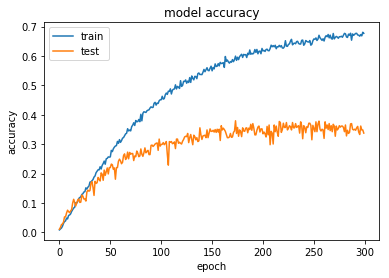

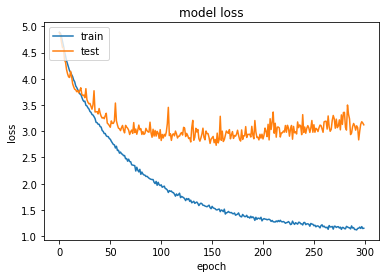

In [22]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [23]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [24]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [25]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [26]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=100, batch_size=133, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 12.32647, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 14.3285 - acc: 0.0370 - val_loss: 12.3265 - val_acc: 0.1030
Epoch 2/100
Epoch 00001: val_loss improved from 12.32647 to 10.48043, saving model to saved_models/weights.best.VGG16.hdf5
0s - loss: 12.5295 - acc: 0.1015 - val_loss: 10.4804 - val_acc: 0.1904
Epoch 3/100
Epoch 00002: val_loss improved from 10.48043 to 9.42599, saving model to saved_models/weights.best.VGG16.hdf5
0s - loss: 11.1839 - acc: 0.1644 - val_loss: 9.4260 - val_acc: 0.2587
Epoch 4/100
Epoch 00003: val_loss improved from 9.42599 to 8.82049, saving model to saved_models/weights.best.VGG16.hdf5
0s - loss: 10.1821 - acc: 0.2290 - val_loss: 8.8205 - val_acc: 0.3162
Epoch 5/100
Epoch 00004: val_loss improved from 8.82049 to 8.50695, saving model to saved_models/weights.best.VGG16.hdf5
0s - loss: 9.5129 - acc: 0.2687 - val_loss: 8.5069 - val_acc: 0.36

Epoch 00051: val_loss improved from 6.73774 to 6.68742, saving model to saved_models/weights.best.VGG16.hdf5
0s - loss: 6.1805 - acc: 0.5843 - val_loss: 6.6874 - val_acc: 0.5066
Epoch 53/100
Epoch 00052: val_loss did not improve
0s - loss: 6.1699 - acc: 0.5865 - val_loss: 6.7676 - val_acc: 0.4994
Epoch 54/100
Epoch 00053: val_loss improved from 6.68742 to 6.67464, saving model to saved_models/weights.best.VGG16.hdf5
0s - loss: 6.1595 - acc: 0.5907 - val_loss: 6.6746 - val_acc: 0.5042
Epoch 55/100
Epoch 00054: val_loss did not improve
0s - loss: 6.1538 - acc: 0.5891 - val_loss: 6.7375 - val_acc: 0.4934
Epoch 56/100
Epoch 00055: val_loss did not improve
0s - loss: 6.1549 - acc: 0.5892 - val_loss: 6.6920 - val_acc: 0.5078
Epoch 57/100
Epoch 00056: val_loss did not improve
0s - loss: 6.1349 - acc: 0.5931 - val_loss: 6.6820 - val_acc: 0.5018
Epoch 58/100
Epoch 00057: val_loss did not improve
0s - loss: 6.1501 - acc: 0.5892 - val_loss: 6.7170 - val_acc: 0.5030
Epoch 59/100
Epoch 00058: val_l

### Load the Model with the Best Validation Loss

In [27]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [28]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 52.0335%


### Predict Dog Breed with the Model

In [29]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

for file in np.random.choice(dog_files, 10):    
    print(os.path.basename(file), VGG16_predict_breed(file))

Australian_shepherd_00888.jpg Pembroke_welsh_corgi
Norwegian_elkhound_07150.jpg Norwegian_elkhound
Golden_retriever_05243.jpg Golden_retriever
Irish_wolfhound_06077.jpg Irish_wolfhound
Norwich_terrier_07234.jpg Norwich_terrier
Afghan_hound_00148.jpg Newfoundland
Collie_03815.jpg Pembroke_welsh_corgi
Smooth_fox_terrier_08119.jpg Smooth_fox_terrier
Australian_shepherd_00808.jpg Welsh_springer_spaniel
Glen_of_imaal_terrier_05160.jpg Glen_of_imaal_terrier


---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [30]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [31]:
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dropout(0.4))
InceptionV3_model.add(Dense(500, activation='relu'))
InceptionV3_model.add(Dropout(0.4))
InceptionV3_model.add(Dense(250, activation='relu'))
InceptionV3_model.add(Dropout(0.4))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dropout_9 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout_10 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               33383     
Total para

### (IMPLEMENTATION) Compile the Model

In [32]:
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [33]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3x.hdf5', 
                               verbose=1, save_best_only=True)

history = InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=100, batch_size=133, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 1.46835, saving model to saved_models/weights.best.InceptionV3x.hdf5
1s - loss: 3.6501 - acc: 0.2400 - val_loss: 1.4684 - val_acc: 0.6719
Epoch 2/100
Epoch 00001: val_loss improved from 1.46835 to 0.81036, saving model to saved_models/weights.best.InceptionV3x.hdf5
1s - loss: 1.7371 - acc: 0.5624 - val_loss: 0.8104 - val_acc: 0.7557
Epoch 3/100
Epoch 00002: val_loss improved from 0.81036 to 0.70792, saving model to saved_models/weights.best.InceptionV3x.hdf5
1s - loss: 1.2814 - acc: 0.6525 - val_loss: 0.7079 - val_acc: 0.7820
Epoch 4/100
Epoch 00003: val_loss improved from 0.70792 to 0.58309, saving model to saved_models/weights.best.InceptionV3x.hdf5
1s - loss: 1.0495 - acc: 0.7018 - val_loss: 0.5831 - val_acc: 0.8084
Epoch 5/100
Epoch 00004: val_loss improved from 0.58309 to 0.56733, saving model to saved_models/weights.best.InceptionV3x.hdf5
1s - loss: 0.9269 - acc: 0.7344 - val_los

Epoch 00062: val_loss did not improve
1s - loss: 0.2347 - acc: 0.9298 - val_loss: 0.7823 - val_acc: 0.8503
Epoch 64/100
Epoch 00063: val_loss did not improve
1s - loss: 0.2305 - acc: 0.9344 - val_loss: 0.8100 - val_acc: 0.8599
Epoch 65/100
Epoch 00064: val_loss did not improve
1s - loss: 0.2310 - acc: 0.9280 - val_loss: 0.8386 - val_acc: 0.8575
Epoch 66/100
Epoch 00065: val_loss did not improve
1s - loss: 0.2179 - acc: 0.9368 - val_loss: 0.8382 - val_acc: 0.8467
Epoch 67/100
Epoch 00066: val_loss did not improve
1s - loss: 0.2213 - acc: 0.9338 - val_loss: 0.8019 - val_acc: 0.8563
Epoch 68/100
Epoch 00067: val_loss did not improve
1s - loss: 0.2318 - acc: 0.9325 - val_loss: 0.8361 - val_acc: 0.8575
Epoch 69/100
Epoch 00068: val_loss did not improve
1s - loss: 0.2478 - acc: 0.9287 - val_loss: 0.8282 - val_acc: 0.8623
Epoch 70/100
Epoch 00069: val_loss did not improve
1s - loss: 0.2392 - acc: 0.9287 - val_loss: 0.7864 - val_acc: 0.8491
Epoch 71/100
Epoch 00070: val_loss did not improve
1s

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [34]:
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3x.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [35]:
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.2632%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [36]:
from extract_bottleneck_features import *

def InceptionV3_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

for file in np.random.choice(dog_files, 10):  
    print(os.path.basename(file), InceptionV3_predict_breed(file))

Anatolian_shepherd_dog_00678.jpg Mastiff
Pharaoh_hound_07744.jpg Pharaoh_hound
English_toy_spaniel_04526.jpg English_toy_spaniel
Saint_bernard_08037.jpg Saint_bernard
Border_collie_02021.jpg Border_collie
Havanese_05597.jpg Havanese
Irish_setter_05828.jpg Irish_setter
Tibetan_mastiff_08163.jpg Tibetan_mastiff
Alaskan_malamute_00315.jpg Alaskan_malamute
Golden_retriever_05233.jpg Golden_retriever


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [37]:
def detector(img_path):
    if dog_detector(img_path):
        predicted_vector = model.predict(path_to_tensor(img_path))
        return "Dog, looks like: " + dog_names[np.argmax(predicted_vector)]
    elif face_detector(img_path):
        predicted_vector = model.predict(path_to_tensor(img_path))
        return "Human, looks like: " + dog_names[np.argmax(predicted_vector)]
    else:
        return "Neither human nor dog"

for file in np.random.choice(np.concatenate([dog_files, human_files]), 10):
    print(detector(file) + " filename: " +  os.path.basename(file))

Human, looks like: French_bulldog filename: Colin_Powell_0117.jpg
Human, looks like: French_bulldog filename: Andy_Rooney_0001.jpg
Human, looks like: Bull_terrier filename: Michelle_Branch_0002.jpg
Dog, looks like: Dalmatian filename: Icelandic_sheepdog_05708.jpg
Dog, looks like: Bull_terrier filename: Pekingese_07605.jpg
Human, looks like: Beauceron filename: Jayson_Williams_0001.jpg
Dog, looks like: Bull_terrier filename: Bullmastiff_02914.jpg
Human, looks like: Bull_terrier filename: Toni_Braxton_0002.jpg
Human, looks like: Curly-coated_retriever filename: Chawki_Armali_0001.jpg
Dog, looks like: Bull_terrier filename: Boston_terrier_02277.jpg


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

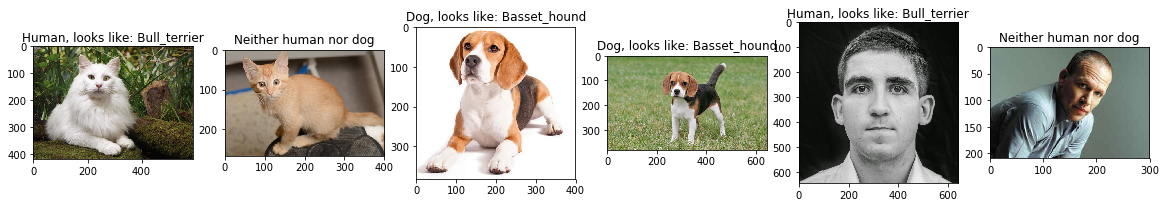

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image

from keras.preprocessing import image               

test_filenames = glob("test_images/*")

test_images = []

for file in test_filenames:
    img = Image.open(file, 'r')
    test_images.append(np.asarray(img))
    
plt.figure(figsize=(20,20))
columns = 6
for i, picture in enumerate(test_images):
    plt.subplot(len(test_images) / columns + 1, columns, i + 1).title.set_text(detector(test_filenames[i]))
    plt.imshow(picture)

## Remarks

Provided that I found results in AIND forum with mostly 15-20% accuracy, I am quite happy about the results I have. These ideas could definitely improve the accuracy of the algorithm:
* There are many images in the dog dataset, which contain other objects and animals. A cleaner dataset could have provided better accuracy
* State of the art CNNs are trained on millions of images while the size of the dog dataset is very small. It is obvious that a much bigger set of data would have given a better algorithm
* I was trying to make the CNN more accurate with trying out different random hyperparameters. Searching for an optimal set of hyperparameters with an algorithm could have given an improved CNN